In [72]:
import kaggle
import os
import pathlib
import zipfile

def download_titanic_dataset():
    data_path = pathlib.Path('titanic')
    if not data_path.exists():
        kaggle.api.competition_download_cli(str(titanic_data_path))
        zipfile.ZipFile(f'{data_path}.zip').extractall(data_path)

titanic_data_path = pathlib.Path('titanic')
if not titanic_data_path.exists():
    download_titanic_dataset()
    print('Done')

In [73]:
import numpy as np
import pandas as pd
import torch

print(f'PyTorch version: {torch.__version__}')

np.set_printoptions(linewidth=85)
torch.set_printoptions(linewidth=85, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 85)

PyTorch version: 2.7.1+cu118


# Cleaning the data

In [74]:
df = pd.read_csv(titanic_data_path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [75]:
#Number of NaN on each column
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [76]:
# Instead of removing the entire row that has a NaN in it
# We will replace NaN with the mode (most frequently occurred value) for that column

modes = df.mode().iloc[0] # In case there is a tie, we choose the first mode
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [77]:
df.fillna(modes, inplace=True)
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [78]:
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


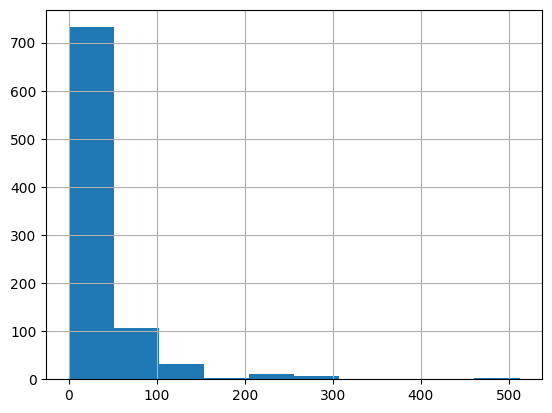

In [79]:
df['Fare'].hist();

# Long tail distribution: lots of small numbers and a few big ones
# Some models don't like long tail distribution, linear is one of them
# One way to transform a long tail distribution is to use log()

<Axes: >

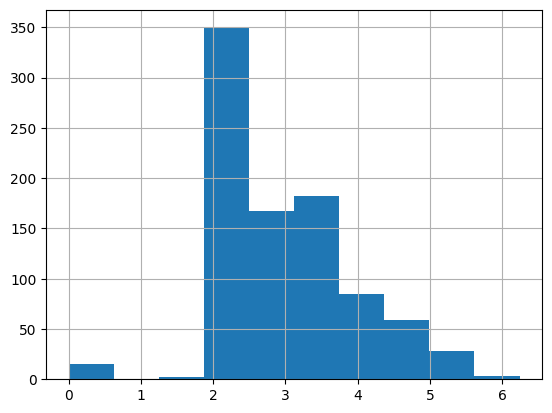

In [80]:
df['LogFare'] = np.log(df['Fare'] + 1) # Add 1 since log of 0 is NaN
df['LogFare'].hist()

In [81]:
pclasses = sorted(df.Pclass.unique())
pclasses

[np.int64(1), np.int64(2), np.int64(3)]

In [82]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Dooley, Mr. Patrick",male,347082,B96 B98,S
freq,1,577,7,691,646


In [83]:
# Can't really multiply Name, Sex or Emabarked by a coefficients during training
# We will create dummy variables

df = pd.get_dummies(df, columns=['Sex', 'Pclass', 'Embarked'])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'LogFare', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [84]:

added_cols = ['Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,False,True,False,False,True,False,False,True
1,True,False,True,False,False,True,False,False
2,True,False,False,False,True,False,False,True
3,True,False,True,False,False,False,False,True
4,False,True,False,False,True,False,False,True


In [85]:
from torch import tensor

# Variable we're trying to predict
t_dep = tensor(df.Survived)

In [86]:
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols
t_indep = tensor(df[indep_cols].values.astype(np.float32), dtype=torch.float32)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  0.0000,  1.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  1.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  1.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  1.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  0.0000,  1.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  0.0000,  1.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  0.0000,  1.0000,  1.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  0.0000,  1.0000,  0.0000,  0.0000,
          1.0000,

In [87]:
t_indep.shape # Returns (rows, cols)

torch.Size([891, 12])

In [88]:
# Length of the shape is called "Rank", or number of dimensions, or number of axises, etc.
# Vector is rank 1, 2D matrix is rank 2, scalar is rank 0
len(t_indep.shape)

2

# Setting up a linear Model

In [89]:
# Only set for academic to make sure the results are reproducible
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff) - 0.5
print(coeffs)
print(f'Shape of coefficients = {coeffs.shape}')
print(f'Shape of t_indep = {t_indep.shape}')

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,
         0.2799, -0.4392,  0.2103,  0.3625])
Shape of coefficients = torch.Size([12])
Shape of t_indep = torch.Size([891, 12])


In [90]:
# A matrix multiplying a vector
# Each row in the matrix is multiplied element-wise by the vector
# This technique is called broadcasting

t_indep * coeffs

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.0000,  -0.3147,   0.0000,
           0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.2632,  -0.0000,   0.4876,
           0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.2632,  -0.0000,   0.0000,
           0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.2632,  -0.0000,   0.4876,
           0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.0000,  -0.3147,   0.0000,
           0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.0000,  -0.3147,   0.0000,
           0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.0000,  -0.3147,   0.4876,
           0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5

In [91]:
# We observe that that first column has significantly larger values than the rest
# The first column is Age, which has bigger number than the rest of the columns
# We will normalize this column by dividing it by the largest age
# The goal is to have all columns to have about the same range

# Get the max of each row
vals, indices = t_indep.max(dim=0) # dim = 0 means getting the max of the rows
t_indep = t_indep / vals

In [92]:
t_indep * coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.0000, -0.3147,  0.0000,  0.0000,
          0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.2632, -0.0000,  0.4876,  0.0000,
          0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.2632, -0.0000,  0.0000,  0.0000,
          0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.2632, -0.0000,  0.4876,  0.0000,
          0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.0000, -0.3147,  0.0000,  0.0000,
          0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.0000, -0.3147,  0.0000,  0.0000,
          0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.0000, -0.3147,  0.4876,  0.0000,
          0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.0000, -0.3147,  0.0000,  0.0000,
          0.2799,

In [93]:
preds = (t_indep * coeffs).sum(axis=1)
preds.shape

torch.Size([891])

In [94]:
preds[:10]

tensor([ 0.1412, -0.5725,  0.1494,  0.2571,  0.0453, -0.0448,  0.0792,  0.2961,
         0.2128, -0.5770])

In [95]:
loss = torch.abs(preds - t_dep).mean()
loss

tensor(0.5200)

In [96]:
def calc_preds(coeffs, indeps):
    return (indeps * coeffs).sum(axis=1)

def calc_loss(coeffs, indeps, deps):
    return torch.abs(calc_preds(coeffs, indeps) - deps).mean()


# Doing Gradient Descent

In [97]:
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,
         0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [98]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5200, grad_fn=<MeanBackward0>)

In [99]:
loss.backward()

In [100]:
coeffs.grad

tensor([-0.0483,  0.0118, -0.0041, -0.0804, -0.1975,  0.1111, -0.1235, -0.0426,
         0.0797, -0.1886, -0.0617,  0.1639])

In [101]:
# Trying out learning rate
lr = 0.1

with torch.no_grad():
    coeffs.sub_(coeffs.grad * lr)
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5056)


# Training the linear model

In [102]:
from fastai.data.transforms import RandomSplitter
train_split_indices, val_split_indices = RandomSplitter(seed=42)(df)

In [103]:
train_indep, val_indep = t_indep[train_split_indices], t_indep[val_split_indices]
train_dep, val_dep = t_dep[train_split_indices], t_dep[val_split_indices]

len(train_dep), len(val_dep)

(713, 178)

In [104]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)

def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, train_indep, train_dep)
    loss.backward()
    with torch.no_grad():
        update_coeffs(coeffs, lr)
    print(f'Loss = {loss:.3f}')

def init_coeffs():
    return (torch.rand(n_coeff) - 0.5).requires_grad_()

def train_model(epochs=30, lr=0.01):
    torch.manual_seed(422)
    coeffs = init_coeffs()
    for i in range(epochs):
        one_epoch(coeffs, lr)
    return coeffs

def show_coeffs():
    return dict(zip(indep_cols, coeffs.requires_grad_(False)))

In [ ]:
coeffs = train_model(epochs=30, lr=0.02)
show_coeffs()

Loss = 0.695
Loss = 0.691
Loss = 0.684
Loss = 0.672
Loss = 0.656
Loss = 0.637
Loss = 0.614
Loss = 0.587
Loss = 0.558
Loss = 0.525
Loss = 0.488
Loss = 0.449
Loss = 0.410
Loss = 0.373
Loss = 0.334
Loss = 0.313
Loss = 0.291
Loss = 0.277


{'Age': tensor(0.0386),
 'SibSp': tensor(-0.1311),
 'Parch': tensor(0.0903),
 'LogFare': tensor(0.2987),
 'Sex_female': tensor(0.2247),
 'Sex_male': tensor(-0.4846),
 'Pclass_1': tensor(0.6652),
 'Pclass_2': tensor(0.3212),
 'Pclass_3': tensor(0.2226),
 'Embarked_C': tensor(0.1805),
 'Embarked_Q': tensor(0.1922),
 'Embarked_S': tensor(0.1136)}

# Measuring Accuracy

In [107]:
preds = calc_preds(coeffs, val_indep)
results = val_dep.bool() == (preds > 0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False,  True,  True, False])

In [108]:
results.float().mean()

tensor(0.7865)

In [ ]:
def accuracy(coeffs):
    return (val_dep.bool() == (calc_preds(coeffs, val_indep) > 0.5)).float().mean()